In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import itertools

In [2]:
training_challenge_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
training_solutions_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_solutions.json'))

In [3]:
# find random keys from the training_challenge_dict
random_keys = list(training_challenge_dict.keys())
n = random.randint(0, len(random_keys))

## Difficult problems
- a64e4611

first challeng: {'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 4, 0, 0, 4, 0, 0, 0], [0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 4, 4, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 4], [4, 0, 0, 0, 1, 4, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 4], [0, 0, 4, 4, 0, 0, 0, 1, 0, 0, 0, 0]]}], 'train': [{'input': [[2, 0, 0, 0, 0, 2, 0, 0, 2], [0, 4, 4, 4, 0, 0, 0, 0, 0], [0, 4, 2, 4, 0, 0, 2, 0, 0], [0, 4, 4, 4, 0, 0, 0, 2, 0], [2, 0, 0, 0, 0, 2, 0, 0, 0]], 'output': [[2]]}, {'input': [[8, 0, 8, 0, 0, 0, 0, 0, 8], [0, 0, 0, 0, 8, 0, 0, 0, 0], [0, 0, 8, 0, 0, 3, 3, 3, 0], [8, 0, 0, 3, 0, 3, 8, 3, 0], [0, 0, 0, 0, 0, 3, 3, 3, 0], [0, 0, 8, 0, 0, 0, 0, 0, 0], [3, 0, 0, 8, 0, 0, 0, 8, 0]], 'output': [[8]]}, {'input': [[1, 2, 0, 0, 0, 2, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [2, 0, 1, 2, 0, 2

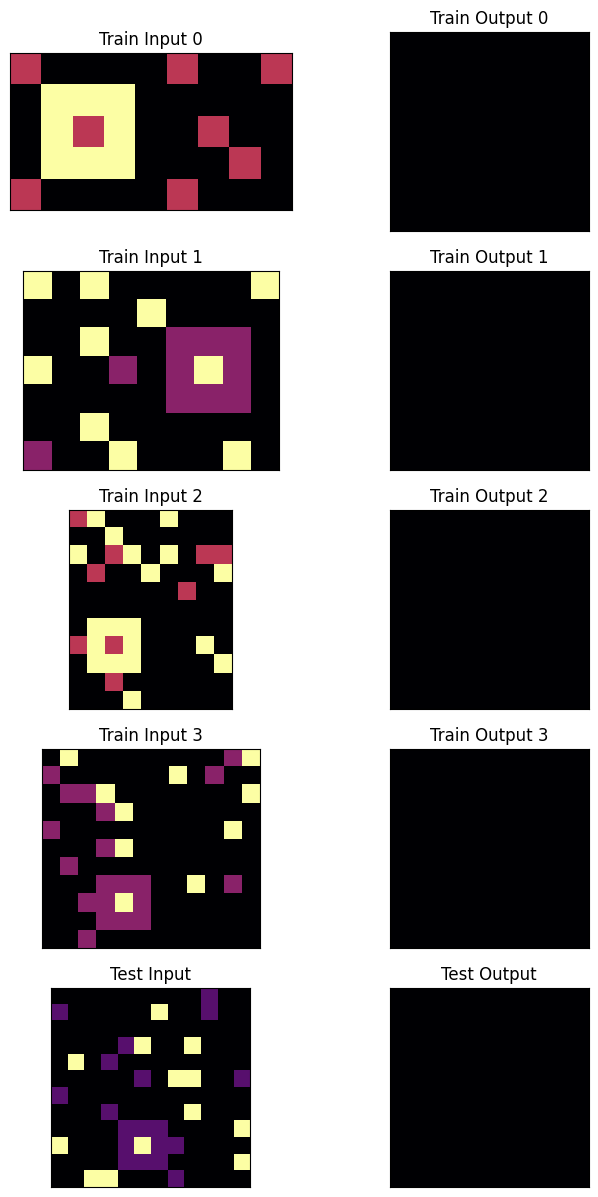

In [4]:
# import the display_challenge function
from dsl.utilities.plot import display_challenge

# find the first challenge and solution
challenge_key = '1f85a75f'
challenge_key = random_keys[n]
first_challenge = training_challenge_dict[challenge_key]
first_solution = training_solutions_dict[challenge_key]

print(f'first challeng: {first_challenge}')
print(f'first solution: {first_solution}')
print(f'Challenge key: {challenge_key}')

# display the challenge
display_challenge(challenge_key)

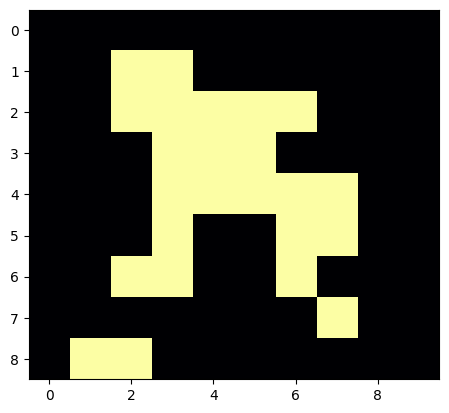

In [5]:
arr = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plt.imshow(arr, cmap='inferno')
plt.show()

In [6]:
from dsl.color_select import ColorSelector

colsel = ColorSelector()

popular_color = colsel.mostcolor(arr)
print(f'Most popular color: {popular_color}')
least_popular_color = colsel.leastcolor(arr)
print(f'Least popular color: {least_popular_color}')

second_most_popular_color = colsel.rankcolor(arr, 1)
print(f'Second most popular color: {second_most_popular_color}')

Most popular color: 0
Least popular color: 1
Second most popular color: 1


Selecting by color


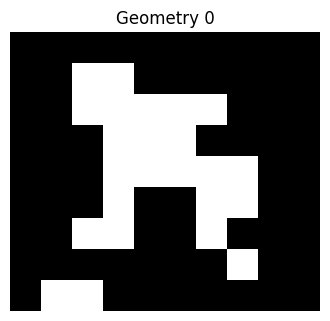

Selecting colored rectange combinations


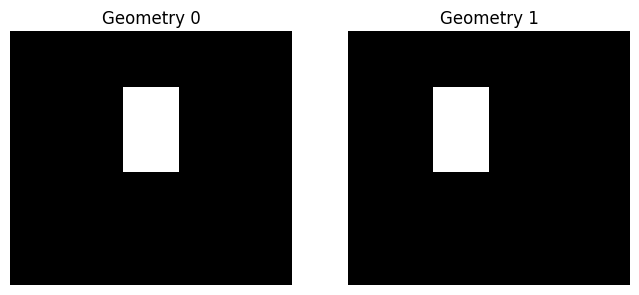

Selecting colored separated shapes


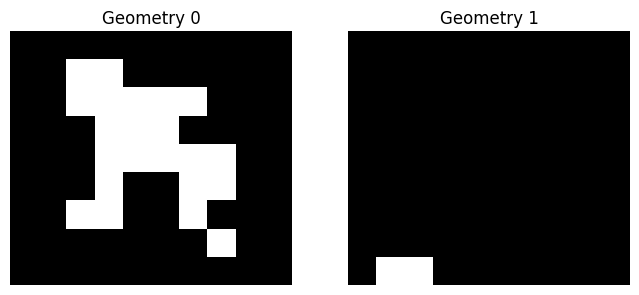

Selecting cells adjacent to color


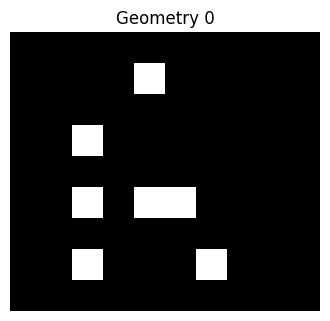

In [7]:
from dsl.select import Selector
from dsl.utilities.plot import plot_selection
sel = Selector(arr.shape)

print('Selecting by color')
selection = sel.select_color(arr, 1)
plot_selection(selection)
print('Selecting colored rectange combinations')
selection2 = sel.select_colored_rectangle_combinations(arr, 1, 3, 2)
plot_selection(selection2)
print('Selecting colored separated shapes')
selection3 = sel.select_colored_separated_shapes(arr, 1)
plot_selection(selection3)
print('Selecting cells adjacent to color')
selection4 = sel.select_adjacent_to_color(arr, 1, 2)
plot_selection(selection4)

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1  0  1  1  0  0  0  0 -1 -1]
  [-1  0  1  1  1  1  1  0 -1 -1]
  [-1  0  0  1  1  1  0  0 -1 -1]
  [-1  0  0  1  1  1  1  1 -1 -1]
  [-1  0  0  1  0  0  1  1 -1 -1]
  [-1  0  1  1  0  0  1  0 -1 -1]
  [-1  0  0  0  0  0  0  1 -1 -1]
  [-1  1  1  0  0  0  0  0 -1 -1]]]


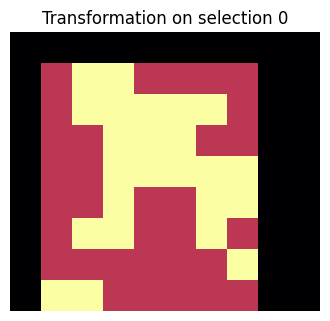

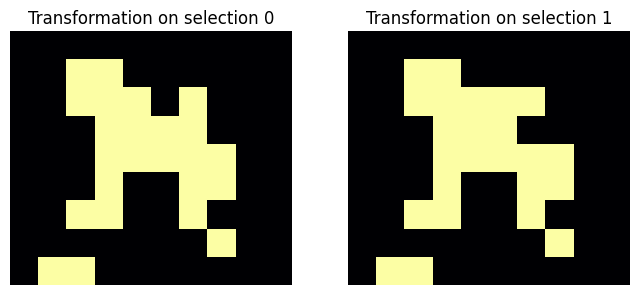

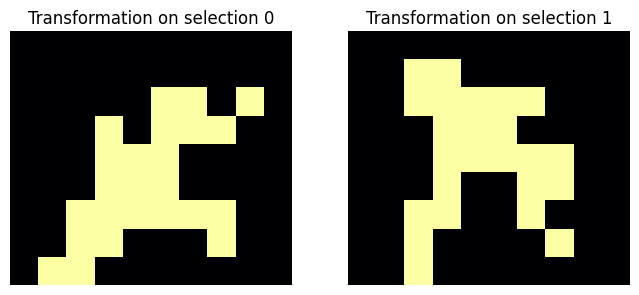

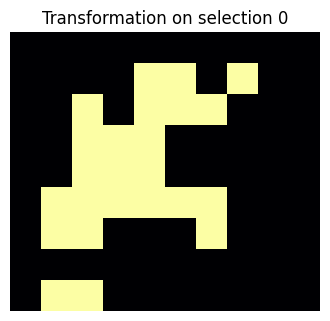

In [8]:
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid

trn = Transformer()

transformed = trn.crop(arr, selection)
print(transformed)
plot_grid(transformed)

transformed2 = trn.rotate(arr, selection2, 1)
plot_grid(transformed2)

transformed3 = trn.rotate(arr, selection3, 1)
plot_grid(transformed3)

transformed4 = trn.rotate(arr, selection4, 1)
plot_grid(transformed4)